# __KMeans Clustering__ #

Loading images from ZIP file...
Applying K-Means clustering...


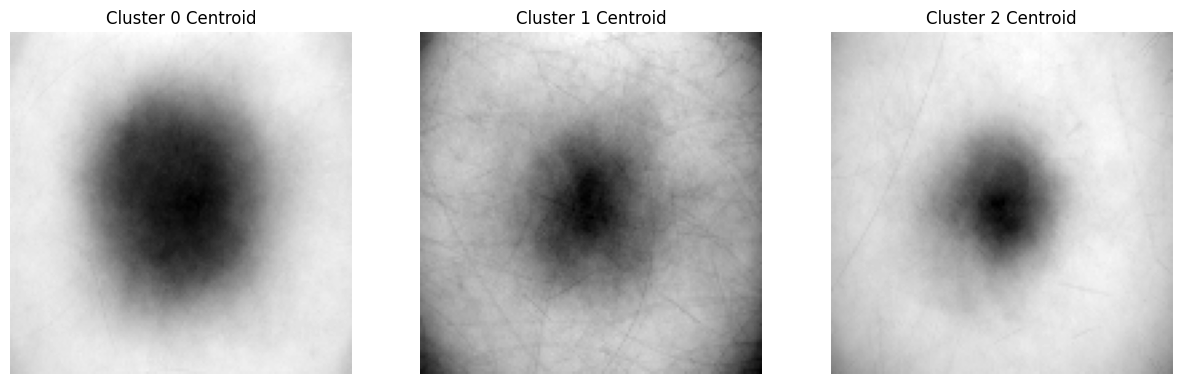

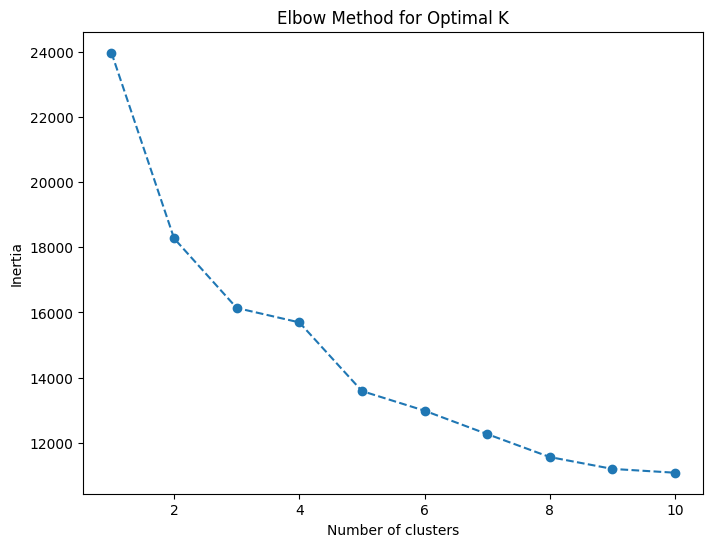

Cluster 0 contains 30 images.


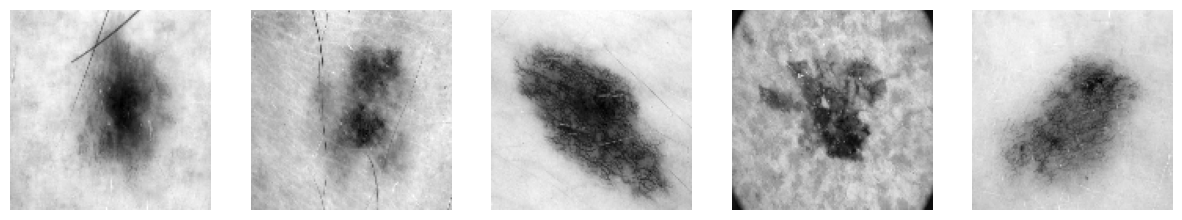

Cluster 1 contains 42 images.


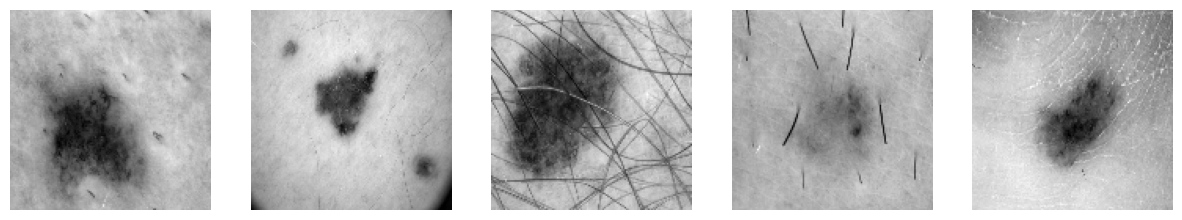

Cluster 2 contains 40 images.


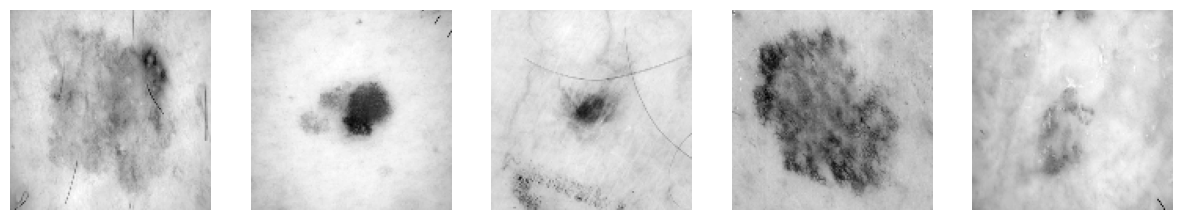

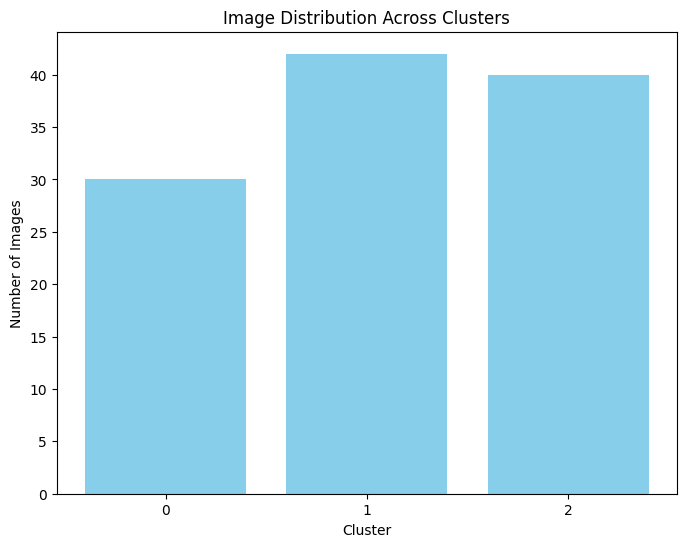

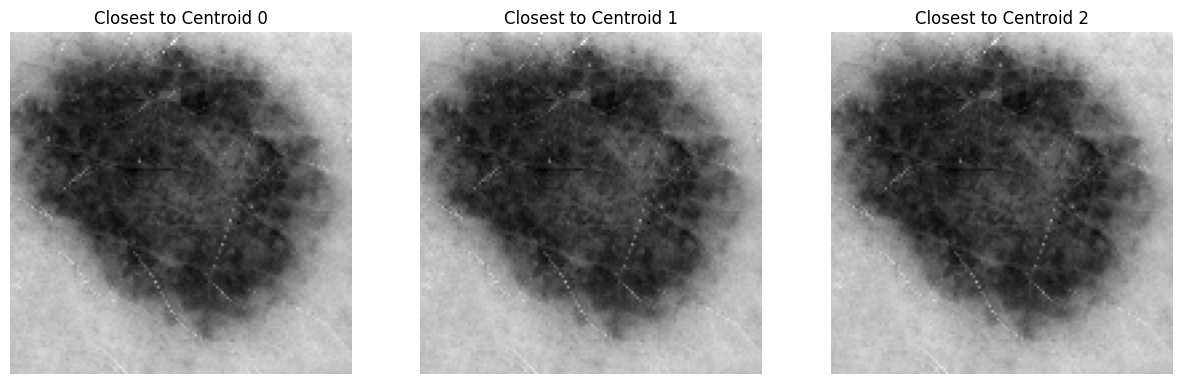

In [ ]:
import os
import cv2
import numpy as np
import zipfile
import io
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

# Path to your ZIP file containing the images
ZIP_FILE_PATH = "/content/Dataset.zip"

# Function to load and preprocess images from a ZIP file
def load_images_from_zip(zip_file, img_size=(128, 128)):
    images = []
    filenames = []
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Iterate over all files in the zip
        for filename in zip_ref.namelist():
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Only process image files
                with zip_ref.open(filename) as file:
                    # Read image from the ZIP file
                    img = np.asarray(bytearray(file.read()), dtype=np.uint8)
                    img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)  # Decode as grayscale
                    if img is not None:
                        img_resized = cv2.resize(img, img_size)  # Resize image
                        images.append(img_resized.flatten())  # Flatten into 1D array
                        filenames.append(filename)
    return np.array(images), filenames

# Load the dataset from the ZIP file
print("Loading images from ZIP file...")
images, filenames = load_images_from_zip(ZIP_FILE_PATH)

# Normalize the data
images_normalized = images / 255.0  # Scale pixel values to [0, 1]

# Apply K-Means clustering
print("Applying K-Means clustering...")
kmeans = KMeans(n_clusters=3, random_state=42)  # Set number of clusters
kmeans.fit(images_normalized)

# Assign images to clusters
labels = kmeans.labels_

# Visualize the cluster centroids
def plot_centroids(kmeans, img_size=(128, 128)):
    centroids = kmeans.cluster_centers_
    n_clusters = centroids.shape[0]
    fig, axs = plt.subplots(1, n_clusters, figsize=(15, 5))
    for i in range(n_clusters):
        centroid_image = centroids[i].reshape(img_size)  # Reshape centroid to image shape
        axs[i].imshow(centroid_image, cmap='gray')
        axs[i].set_title(f"Cluster {i} Centroid")
        axs[i].axis('off')
    plt.show()

# Plot the centroids
plot_centroids(kmeans)

# Elbow Method: Plot the inertia (sum of squared distances to centroids) for different cluster sizes
def plot_elbow_method(images_normalized, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(images_normalized)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', linestyle='--')
    plt.title("Elbow Method for Optimal K")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()

# Plot Elbow Method to determine the best number of clusters
plot_elbow_method(images_normalized)

# Visualize results: Clustered images
def plot_clusters(images, labels, n_clusters, img_size=(128, 128)):
    for cluster in range(n_clusters):
        cluster_images = images[labels == cluster]
        print(f"Cluster {cluster} contains {len(cluster_images)} images.")
        fig, axs = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(min(5, len(cluster_images))):  # Show up to 5 images per cluster
            axs[i].imshow(cluster_images[i].reshape(img_size), cmap='gray')
            axs[i].axis('off')
        plt.show()

# Convert labels and images for plotting
plot_clusters(images, labels, kmeans.n_clusters)

# Visualize image distribution across clusters
def plot_image_distribution(labels, n_clusters):
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title("Image Distribution Across Clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Images")
    plt.xticks(range(n_clusters))
    plt.show()

# Plot the distribution of images in each cluster
plot_image_distribution(labels, kmeans.n_clusters)

# Visualize the closest images to each centroid
def plot_closest_images_to_centroids(images, kmeans, n_images=5, img_size=(128, 128)):
    closest_idx = []
    for i in range(kmeans.n_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        closest, _ = pairwise_distances_argmin_min(cluster_center.reshape(1, -1), images)
        closest_idx.append(closest)

    fig, axs = plt.subplots(1, len(closest_idx), figsize=(15, 5))
    for i, idx in enumerate(closest_idx):
        axs[i].imshow(images[idx[0]].reshape(img_size), cmap='gray')
        axs[i].set_title(f"Closest to Centroid {i}")
        axs[i].axis('off')
    plt.show()

# Plot the images closest to each centroid
plot_closest_images_to_centroids(images, kmeans)

# __KNN Classifier__ #

100%|██████████| 94.3M/94.3M [00:00<00:00, 221MB/s]


Extracting ./data/eurosat/EuroSAT.zip to ./data/eurosat
Confusion Matrix:
[[621   0]
 [ 48 431]]

Classification Report:
              precision    recall  f1-score   support

      Forest       0.93      1.00      0.96       621
  Industrial       1.00      0.90      0.95       479

    accuracy                           0.96      1100
   macro avg       0.96      0.95      0.96      1100
weighted avg       0.96      0.96      0.96      1100



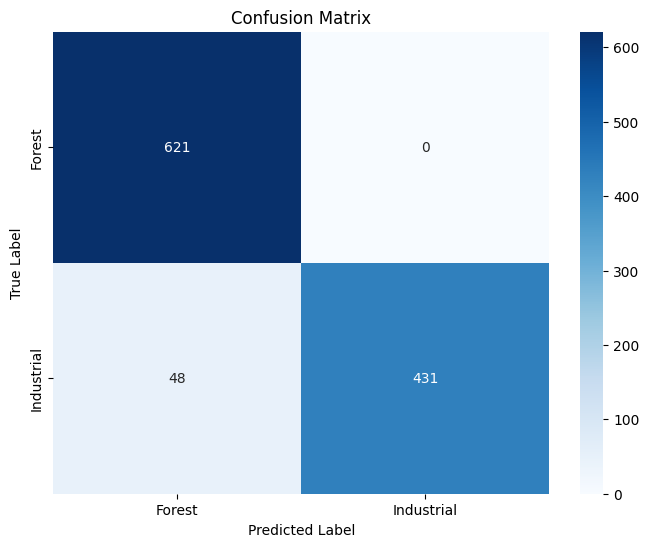

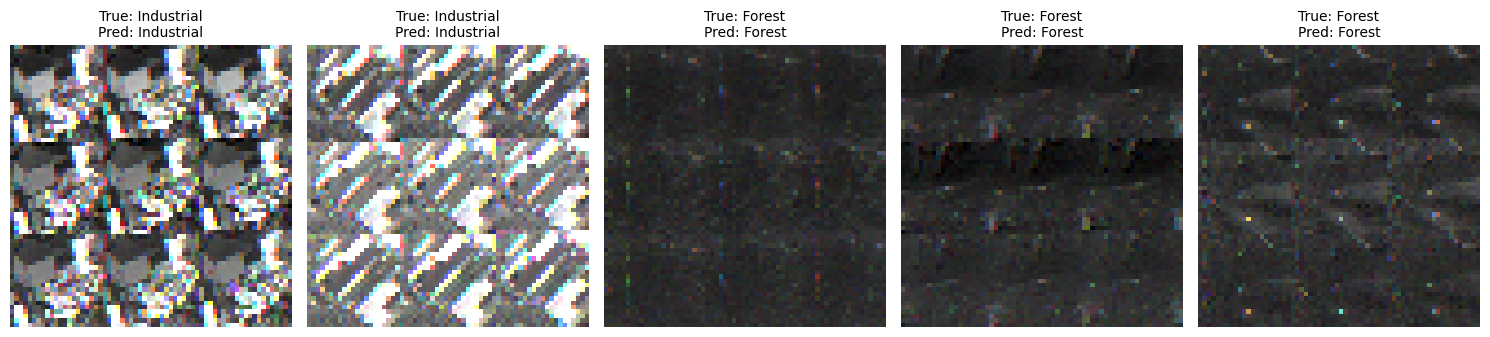

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import datasets, transforms

# Step 1: Download and preprocess the dataset
def load_eurosat_data(classes=("Forest", "Industrial")):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    dataset = datasets.EuroSAT(
        root="./data",
        download=True,
        transform=transform
    )
    # Filter classes
    class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}
    selected_idx = [class_to_idx[cls] for cls in classes]

    data = []
    labels = []
    for img, label in dataset:
        if label in selected_idx:
            data.append(img.numpy().flatten())  # Flatten image to 1D array
            labels.append(selected_idx.index(label))

    return np.array(data), np.array(labels), classes

# Step 2: Load data and split into train-test
data, labels, classes = load_eurosat_data(classes=("Forest", "Industrial"))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

# Step 5: Visualize some predictions
# 5.1: Plot Confusion Matrix using Seaborn
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, classes)

# __MLP Classifier__ #

Displaying some sample images from the dataset:


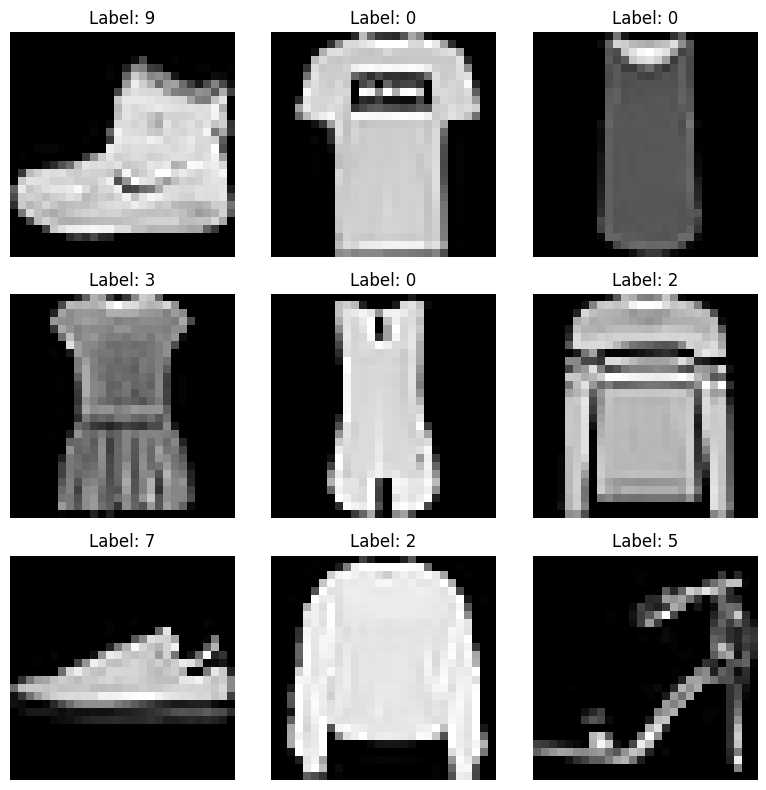

Iteration 1, loss = 0.48101348
Iteration 2, loss = 0.34360682
Iteration 3, loss = 0.30287016
Iteration 4, loss = 0.27744944
Iteration 5, loss = 0.25565181
Iteration 6, loss = 0.23760539
Iteration 7, loss = 0.22149587
Iteration 8, loss = 0.20934352
Iteration 9, loss = 0.19657698
Iteration 10, loss = 0.18357708
Iteration 11, loss = 0.17733607
Iteration 12, loss = 0.16571028
Iteration 13, loss = 0.15802770
Iteration 14, loss = 0.14783536
Iteration 15, loss = 0.13906255
Iteration 16, loss = 0.13149857
Iteration 17, loss = 0.12700344
Iteration 18, loss = 0.11925445
Iteration 19, loss = 0.11455294
Iteration 20, loss = 0.10904659
Iteration 21, loss = 0.10564960
Iteration 22, loss = 0.10279305
Iteration 23, loss = 0.09766799
Iteration 24, loss = 0.09041893
Iteration 25, loss = 0.08739744
Iteration 26, loss = 0.08578446
Iteration 27, loss = 0.07828135
Iteration 28, loss = 0.07265761
Iteration 29, loss = 0.06985109
Iteration 30, loss = 0.06908915
Displaying the training loss curve:


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


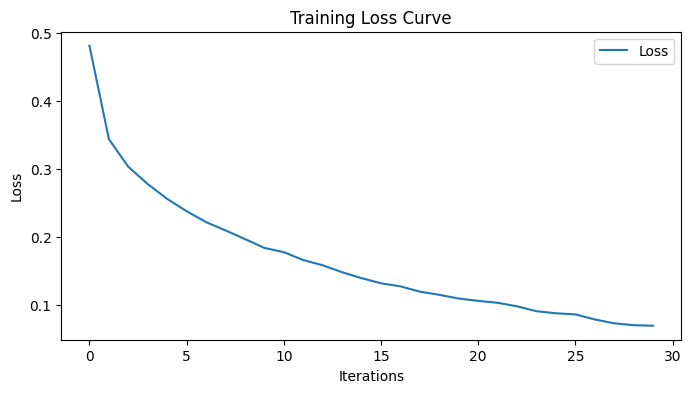

Accuracy: 89.25%

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1394
           1       0.98      0.98      0.98      1402
           2       0.84      0.80      0.82      1407
           3       0.91      0.90      0.90      1449
           4       0.82      0.82      0.82      1357
           5       0.98      0.95      0.96      1449
           6       0.71      0.75      0.73      1407
           7       0.95      0.96      0.95      1359
           8       0.96      0.97      0.97      1342
           9       0.95      0.96      0.96      1434

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
X, y = fashion_mnist["data"], fashion_mnist["target"]

# Visualize some sample images
def plot_sample_images(X, y, num_images=9):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')  # .values converts to numpy array
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Displaying some sample images from the dataset:")
plot_sample_images(X, y)

# Step 2: Normalize pixel values to [0, 1]
X = X / 255.0  # Scale pixel values

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Apply Standard Scaler (optional but recommended for MLPClassifier)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Create a neural network model
clf = MLPClassifier(hidden_layer_sizes=(128,), max_iter=30, random_state=42, solver='adam', verbose=True)

# Step 6: Train the model and capture loss curve
clf.fit(X_train, y_train)

# Plot loss curve
def plot_loss_curve(clf):
    loss_curve = clf.loss_curve_
    plt.figure(figsize=(8, 4))
    plt.plot(loss_curve, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

print("Displaying the training loss curve:")
plot_loss_curve(clf)

# Step 7: Predict on the test set
y_pred = clf.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# __Bayes__ #

Displaying some sample images from the dataset:


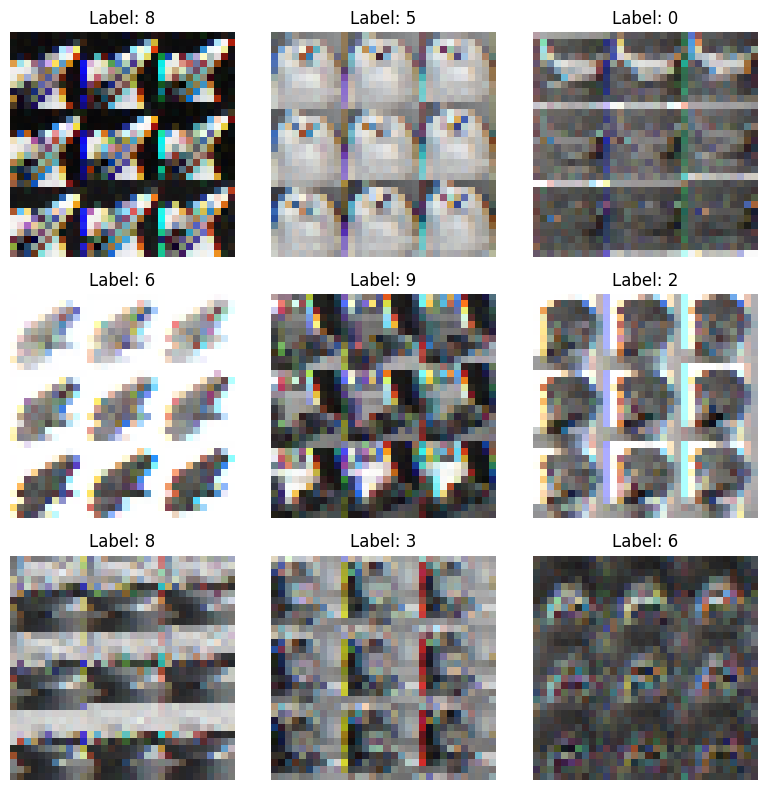

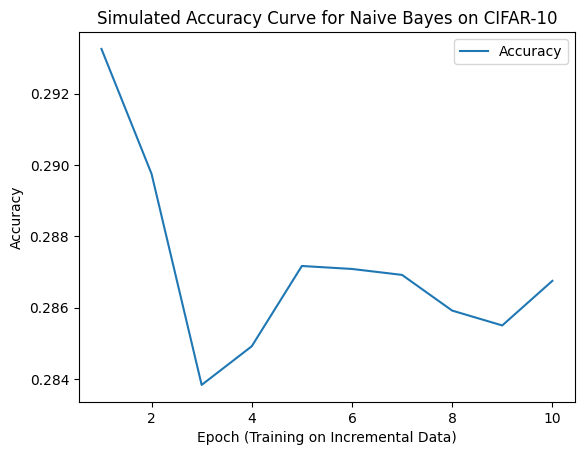

Final Accuracy: 28.68%

Classification Report:

              precision    recall  f1-score   support

           0       0.26      0.46      0.33      1193
           1       0.38      0.17      0.24      1211
           2       0.19      0.08      0.11      1218
           3       0.23      0.07      0.11      1208
           4       0.22      0.44      0.29      1168
           5       0.30      0.24      0.27      1203
           6       0.26      0.44      0.33      1185
           7       0.41      0.12      0.18      1241
           8       0.38      0.47      0.42      1183
           9       0.35      0.39      0.37      1190

    accuracy                           0.29     12000
   macro avg       0.30      0.29      0.27     12000
weighted avg       0.30      0.29      0.26     12000



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import fetch_openml

# Step 1: Load the CIFAR-10 dataset from OpenML
cifar10 = fetch_openml('cifar_10', version=1)
X, y = cifar10["data"], cifar10["target"]

# Normalize pixel values to [0, 1]
X = X / 255.0  # Scale pixel values

# Visualize some sample images
def plot_sample_images(X, y, num_images=9):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X.iloc[i].values.reshape(32, 32, 3))  # Reshape for 32x32 RGB images
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Displaying some sample images from the dataset:")
plot_sample_images(X, y)

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Apply Standard Scaler (Gaussian Naive Bayes assumes Gaussian distribution, so scaling helps)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Create a Naive Bayes model (GaussianNB)
clf = GaussianNB()

# Step 5: Simulate training loss curve (accuracy over increments)
accuracies = []

# Example of simulating training on incremental chunks of data
for i in range(1, 11):  # Simulating training on incremental chunks of data
    clf.fit(X_train[:i * len(X_train) // 10], y_train[:i * len(y_train) // 10])
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot simulated "accuracy over epochs"
plt.plot(range(1, 11), accuracies, label="Accuracy")
plt.xlabel("Epoch (Training on Incremental Data)")
plt.ylabel("Accuracy")
plt.title("Simulated Accuracy Curve for Naive Bayes on CIFAR-10")
plt.legend()
plt.show()

# Final model evaluation
y_pred = clf.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {final_accuracy * 100:.2f}%")

# Display classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))